In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate , Add, Dot, Activation, Lambda, BatchNormalization, LeakyReLU, Softmax
from tensorflow.keras.models import Model

from tensorflow.image import flip_up_down, flip_left_right, rot90
from tensorflow.linalg import normalize

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math

import matplotlib.pyplot as plt
import sys 
sys.path.append('..')
from layers.sorted_filters import SortedConv2D

import datetime


c:\Users\Liam_gaming\anaconda3\envs\sys809\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.python.client import device_lib
#tf.disable_v2_behavior()

#print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.__version__ )

Num GPUs Available:  1
2.9.1


In [3]:
input_net = Input((32, 32, 3))

y = SortedConv2D(filters=32,activation=LeakyReLU(alpha=0.1), padding='SAME')(input_net)
#y = layers.Dropout(0.5)(y)
y = layers.BatchNormalization(axis=-1)(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 



y = SortedConv2D(filters=64,activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
#y = SortedConv2D(filters=64,activation=LeakyReLU(alpha=0.3), padding='SAME')(y)
#y = layers.Dropout(0.5)(y)
y = layers.BatchNormalization(axis=-1)(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 



y = SortedConv2D(filters=128, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
y = layers.BatchNormalization(axis=-1)(y)
y = SortedConv2D(filters=256, activation=LeakyReLU(alpha=0.1), padding='SAME')(y)
#y = SortedConv2D(filters=128, activation=LeakyReLU(alpha=0.3), padding='SAME')(y)
#y = layers.Dropout(0.5)(y)
y = layers.BatchNormalization(axis=-1)(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 

y = layers.Flatten()(y)
y = layers.Dense(1024, activation=LeakyReLU(alpha=0.1))(y)
#y = layers.BatchNormalization(axis=-1)(y)
y = layers.Dropout(0.2)(y)
output_net  = layers.Dense(100, activation=Softmax())(y)

model = Model(inputs = input_net, outputs = output_net)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sorted_conv2d (SortedConv2D  (None, 32, 32, 32)       322       
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 sorted_conv2d_1 (SortedConv  (None, 16, 16, 64)       6210      
 2D)                                                         

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


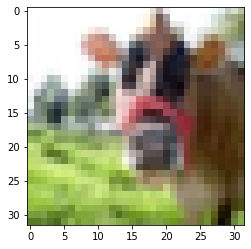

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()



# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

plt.imshow(x_train[0,:,:,:])

In [5]:
model = Model(inputs = input_net, outputs = output_net)

initial_learning_rate =  0.05

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    alpha = 0.000001,
    m_mul=1.0,
    first_decay_steps = 20)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

log_dir = "logs2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
)


checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

batch_size = 250
epochs = 200
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/200
200/200 [==============================] - 13s 44ms/step - loss: 297.5387 - accuracy: 0.0112 - top-5-accuracy: 0.2414 - val_loss: 59.9398 - val_accuracy: 0.0141 - val_top-5-accuracy: 0.0670
Epoch 2/200
200/200 [==============================] - 9s 43ms/step - loss: 142.7497 - accuracy: 0.0123 - top-5-accuracy: 0.1565 - val_loss: 37.5117 - val_accuracy: 0.0100 - val_top-5-accuracy: 0.0500
Epoch 3/200
 69/200 [=========>....................] - ETA: 4s - loss: 34.3131 - accuracy: 0.0109 - top-5-accuracy: 0.0576

KeyboardInterrupt: 

In [ ]:
%load_ext tensorboard


In [ ]:
%tensorboard --logdir=/logs2/fit

Reusing TensorBoard on port 6006 (pid 19780), started 1:43:10 ago. (Use '!kill 19780' to kill it.)

1/1 [==============================] - 0s 294ms/step
[59] 59
(1, 32, 32, 16)
[[-47.550003  -61.059666  -62.927563  ... -63.432785  -63.061604
  -50.775303 ]
 [-57.004047  -70.381516  -73.28015   ... -73.94008   -73.638405
  -62.167774 ]
 [-56.51859   -70.72879   -73.42403   ... -74.40538   -74.046745
  -62.415104 ]
 ...
 [ -4.5419436  -4.9502845  -5.11405   ...  -7.1429253  -6.959328
   -6.1966558]
 [ -4.5151205  -4.928056   -5.0343614 ...  -7.564119   -7.6633453
   -6.950587 ]
 [ -4.1649466  -4.4559827  -4.511749  ...  -6.673801   -7.1749606
   -6.5882344]]


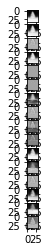

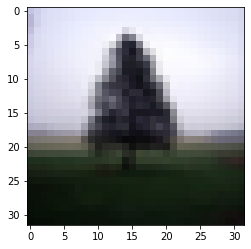

In [ ]:
get_layer_output = K.function([model.input], model.layers[1].output)

n = 109

X = np.expand_dims(x_test[n], axis=0)
print(y_test[n], np.argmax(model.predict(X)))


layer_out = np.array(get_layer_output([X]))
print(layer_out.shape)

print(layer_out[0, :,:, 0])
fig, ax = plt.subplots(16)
for i in range(16):
    ax[i].imshow(layer_out[0, :,:, i],  cmap='gray')   

plt.figure(2)  
plt.imshow(x_test[n],  cmap='gray')   

 

In [ ]:
model.layers[4].trainable_variables[3].name

IndexError: list index out of range

In [ ]:
model.layers[1].scale_s

<tf.Variable 'sorted_conv2d/scale_sym:0' shape=() dtype=float32, numpy=-0.0684901>

In [ ]:
model.layers[1].get_sym_filter(0,3) 

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 1.057311  , -0.15671223,  1.057311  ],
       [-0.15671223, -0.23184319, -0.15671223],
       [ 1.057311  , -0.15671223,  1.057311  ]], dtype=float32)>